# Setup

In [3]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
total = len(fits)

R2_threshold = 0.5
R2_filter = (fits.R2_1 > R2_threshold) & (fits.R2_2 > R2_threshold)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Good systems: 3782/15000 (25.21%)


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V1,Pttv1,phase1,A2,B2,V2,Pttv2,phase2,R2_1,R2_2
0,11,0.029645,24.145110,0.011246,16.467555,-0.015178,3,7,10.340634,0.961805,...,0.004003,235.523244,3.829082,0.000060,-3.476826e-08,0.000513,235.467789,0.451020,0.956844,0.975182
1,13,0.002361,61.077446,0.001129,7.875732,-0.049101,2,7,13.312584,0.968069,...,1.874309,127.994052,0.866634,0.000170,-1.211450e-06,0.001149,127.110242,3.965051,0.952068,0.976353
2,15,0.021439,310.637919,0.003320,354.781909,0.014282,3,7,10.649965,1.081706,...,0.168619,179.156416,0.174186,-0.000025,3.240513e-09,0.001215,179.496807,3.287031,0.950029,0.938810
3,16,0.035138,122.408935,0.001879,39.100954,-0.017912,4,7,9.166152,0.330639,...,0.004831,128.716442,1.905461,0.000027,-8.164824e-08,0.000487,129.122713,5.047181,0.937548,0.943107
4,18,0.001950,94.576312,0.003211,28.073961,0.051603,2,7,14.722442,20.647173,...,0.003014,143.974990,0.326334,-0.000068,2.538630e-08,0.000560,144.156656,3.756945,0.988059,0.966206


In [4]:
# Functions, returns in %
def err_gmean(calc, sol):
    gavg = gmean(calc/sol)
    return (gavg - 1) * 100

def err_med(calc, sol):
    gavg = np.median(calc/sol)
    return (gavg - 1) * 100

def err_gstd(calc, sol):
    logs = np.log(calc/sol)
    gstd = np.exp(logs.std(ddof=0))
    return gstd * 100

def returnMetrics(df, mask='all'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])
    gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
    gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])

    return err1, err2, med1, med2, gstd1, gstd2

# Non-nominal validation

In [5]:
# Naive validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|█████████████████████████████████████████████████████████████████████████████| 3782/3782 [00:37<00:00, 100.96it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,11,0.029645,24.145110,0.011246,16.467555,-0.015178,3,7,10.340634,0.961805,...,-3.476826e-08,0.000513,235.467789,0.451020,0.956844,0.975182,1.232074,11.421769,0.424384,4.893171
1,13,0.002361,61.077446,0.001129,7.875732,-0.049101,2,7,13.312584,0.968069,...,-1.211450e-06,0.001149,127.110242,3.965051,0.952068,0.976353,18.069147,17841.980601,26.143533,23405.157362
2,15,0.021439,310.637919,0.003320,354.781909,0.014282,3,7,10.649965,1.081706,...,3.240513e-09,0.001215,179.496807,3.287031,0.950029,0.938810,1.594103,326.388175,2.547691,465.350849
3,16,0.035138,122.408935,0.001879,39.100954,-0.017912,4,7,9.166152,0.330639,...,-8.164824e-08,0.000487,129.122713,5.047181,0.937548,0.943107,0.343428,4.196845,0.609143,7.699141
4,18,0.001950,94.576312,0.003211,28.073961,0.051603,2,7,14.722442,20.647173,...,2.538630e-08,0.000560,144.156656,3.756945,0.988059,0.966206,13.334336,34.603677,6.841396,24.416069


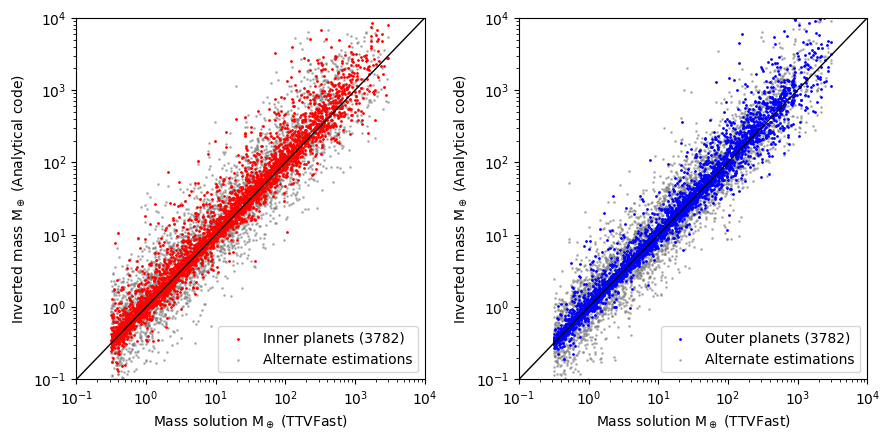

In [6]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(9, 4.5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4
scatterCount = len(compare['m1'])

# Inner planets
ax[0].scatter(compare['m1'], compare['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare['m1'], compare['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare['m2'], compare['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare['m2'], compare['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

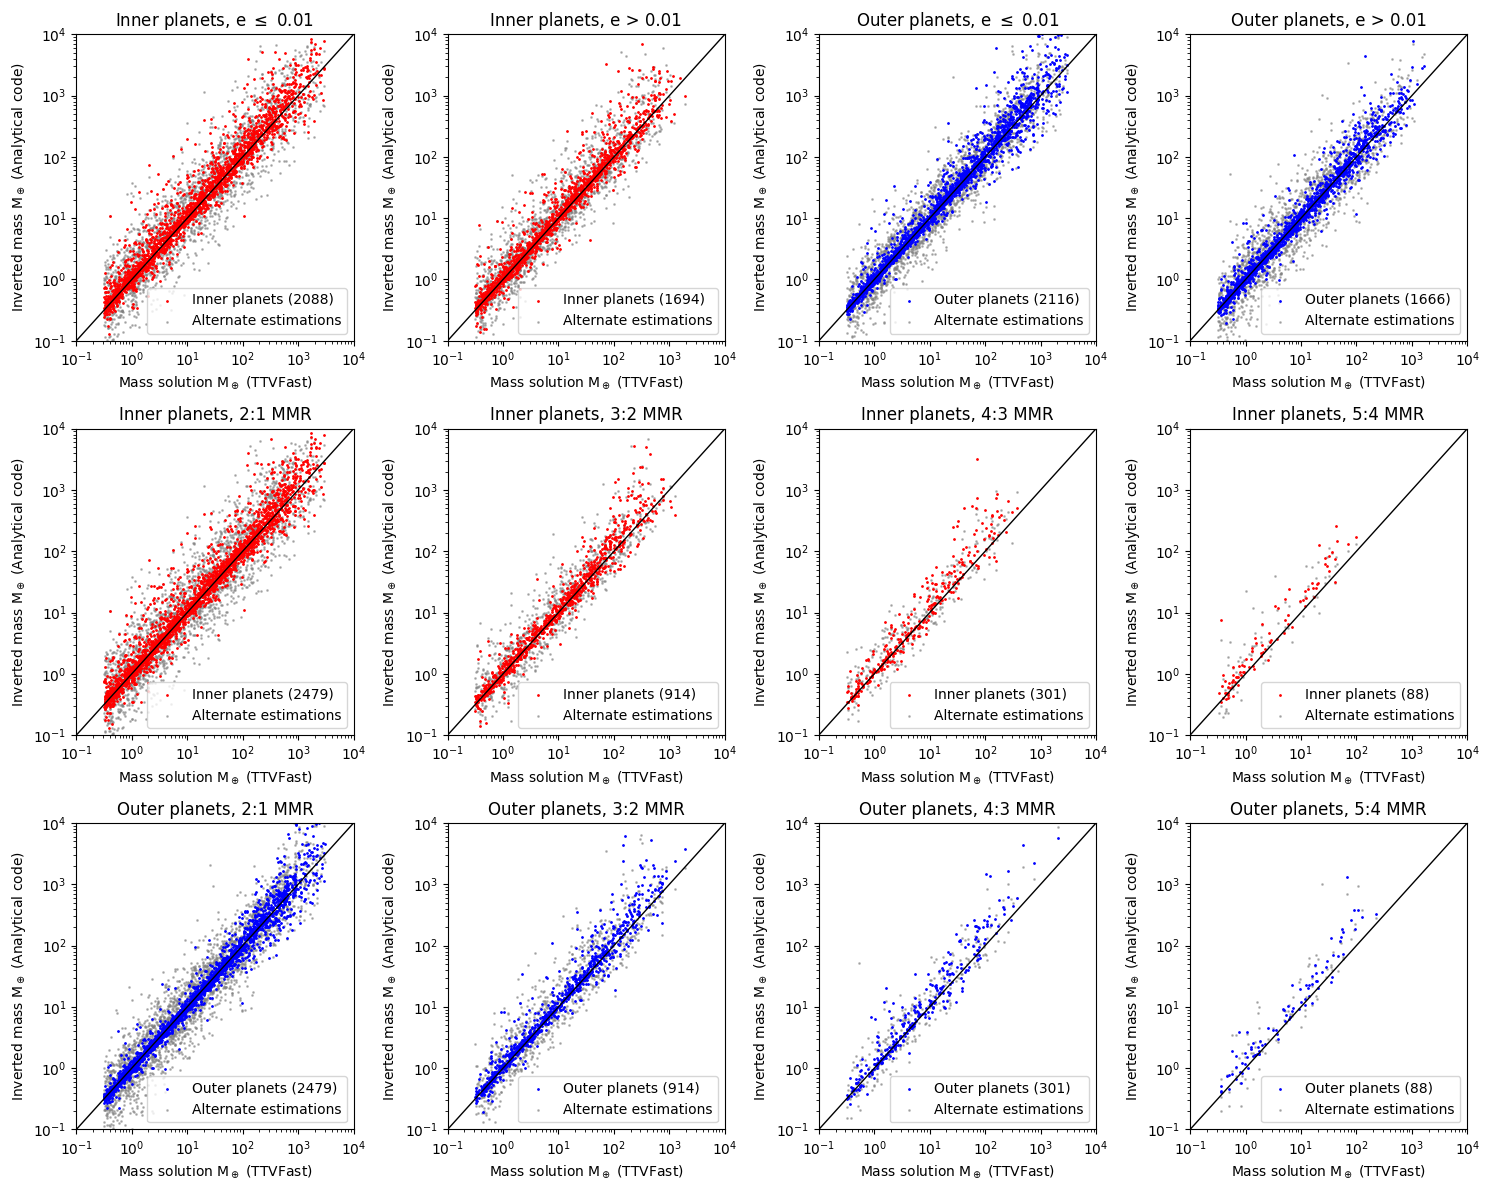

In [7]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(15, 12))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName):
    s = 1
    minval = 1e-1
    maxval = 1e+4
    scatterCount = len(x[mask])
    
    ax[posTuple].scatter(x[mask], ygood[mask], s=s, color=color, label=f'{innerouterStr} planets ({scatterCount})', zorder=0)
    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
    ax[posTuple].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval, maxval); ax[posTuple].set_ylim(minval, maxval)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName}')

def plotMassWithRegimes(df):
    # Regime definitions
    ethres = 0.01
    lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
    lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
    def jmask(n): 
        return (compare.j == n)
    
    # Eccentricity
    plotMassEstimation((0,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', lowe1, 'e $\leq$ 0.01')
    plotMassEstimation((0,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', highe1, 'e > 0.01')
    plotMassEstimation((0,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', lowe2, 'e $\leq$ 0.01')
    plotMassEstimation((0,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', highe2, 'e > 0.01')
    
    # MMR
    plotMassEstimation((1,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(2), '2:1 MMR')
    plotMassEstimation((1,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(3), '3:2 MMR')
    plotMassEstimation((1,2), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(4), '4:3 MMR')
    plotMassEstimation((1,3), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(5), '5:4 MMR')
    
    plotMassEstimation((2,0), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(2), '2:1 MMR')
    plotMassEstimation((2,1), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(3), '3:2 MMR')
    plotMassEstimation((2,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(4), '4:3 MMR')
    plotMassEstimation((2,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(5), '5:4 MMR')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [10]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 22.66%, 10.34%, 172.88%
Geometric mean error, median error, and geometric STD (Outer): 13.28%, 5.35%, 157.16%


# Nominal validation

In [11]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|█████████████████████████████████████████████████████████████████████████████| 3782/3782 [00:36<00:00, 104.43it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,11,0.029645,24.145110,0.011246,16.467555,-0.015178,3,7,10.340634,0.961805,...,-3.476826e-08,0.000513,235.467789,0.451020,0.956844,0.975182,0.885047,10.829474,0.949862,12.221576
1,13,0.002361,61.077446,0.001129,7.875732,-0.049101,2,7,13.312584,0.968069,...,-1.211450e-06,0.001149,127.110242,3.965051,0.952068,0.976353,17.398214,17521.179519,28.539062,23926.049040
2,15,0.021439,310.637919,0.003320,354.781909,0.014282,3,7,10.649965,1.081706,...,3.240513e-09,0.001215,179.496807,3.287031,0.950029,0.938810,2.713146,588.345518,2.985116,689.737543
3,16,0.035138,122.408935,0.001879,39.100954,-0.017912,4,7,9.166152,0.330639,...,-8.164824e-08,0.000487,129.122713,5.047181,0.937548,0.943107,1.124449,15.204404,1.279641,18.422946
4,18,0.001950,94.576312,0.003211,28.073961,0.051603,2,7,14.722442,20.647173,...,2.538630e-08,0.000560,144.156656,3.756945,0.988059,0.966206,12.173604,33.596986,7.514593,25.470536


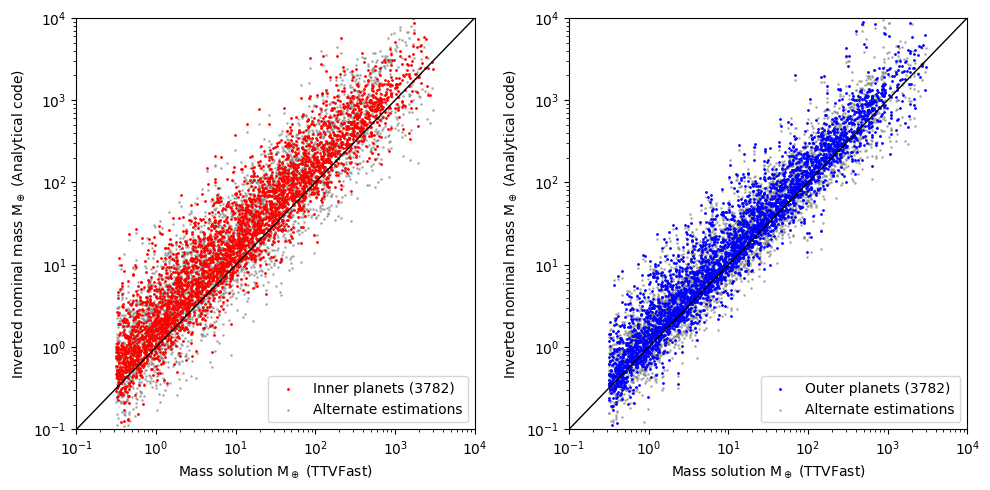

In [12]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4

scatterCount = len(compare_n['m1'])

# Inner planets
ax[0].scatter(compare_n['m1'], compare_n['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare_n['m1'], compare_n['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare_n['m2'], compare_n['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare_n['m2'], compare_n['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

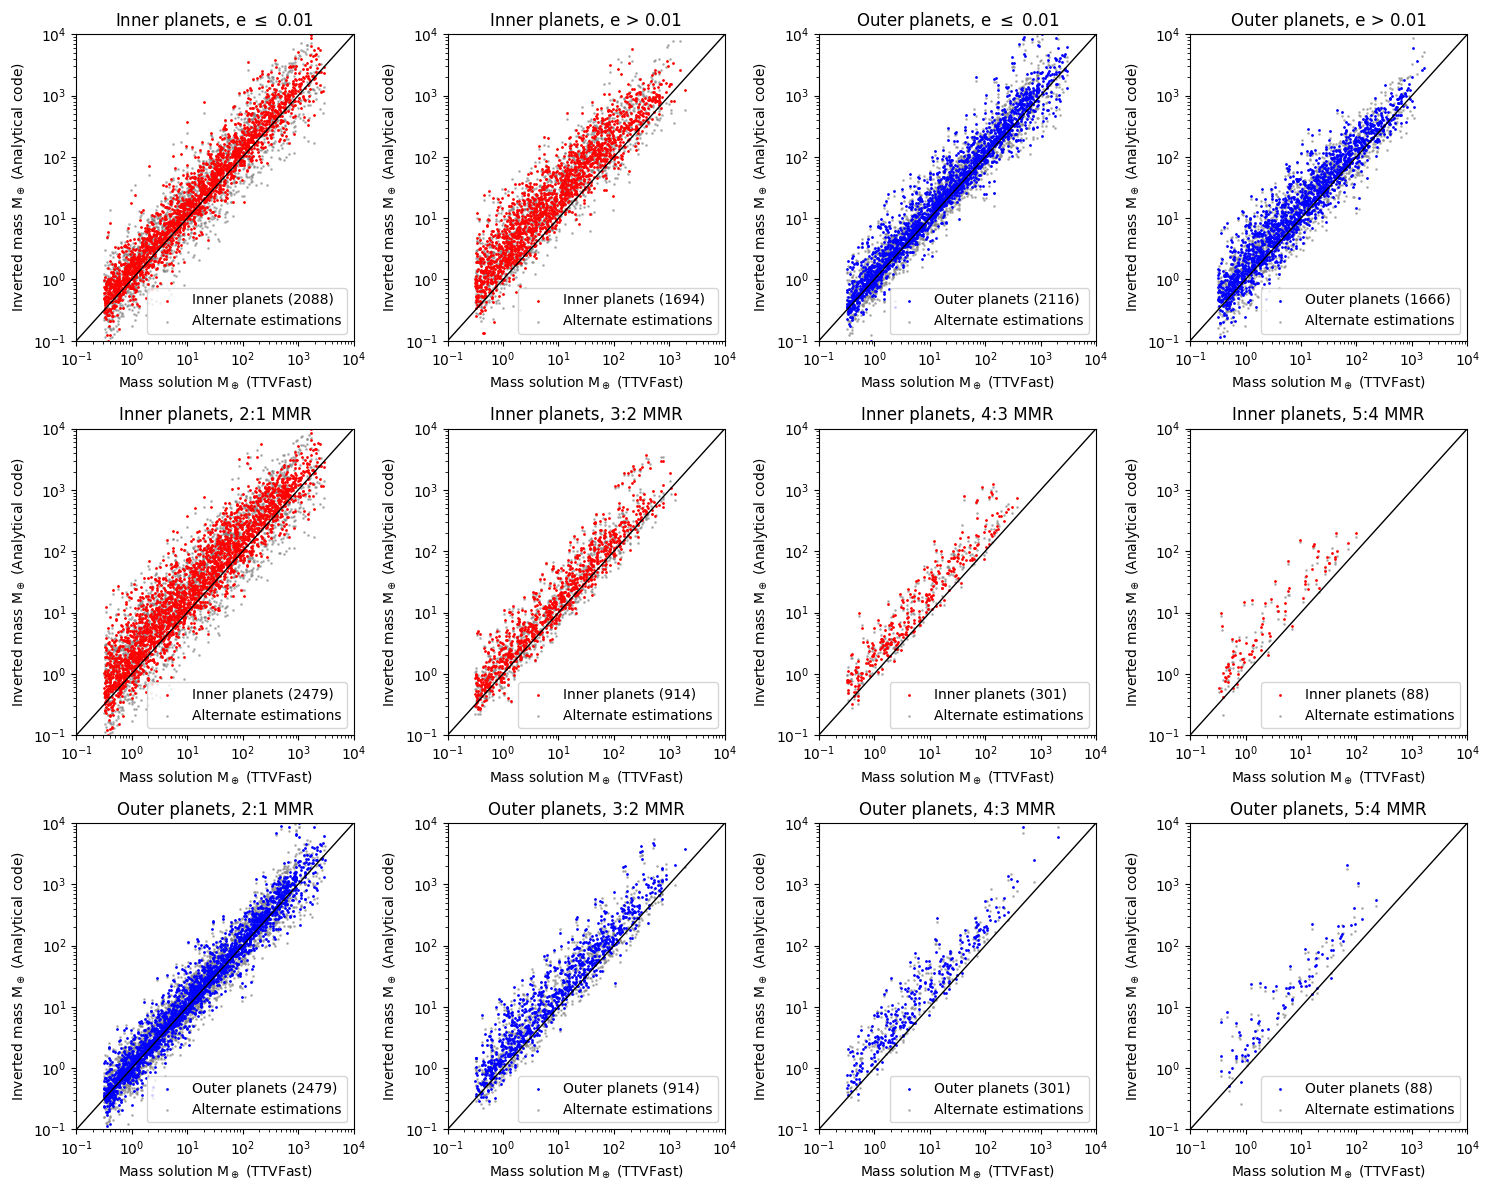

In [13]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(15, 12))
plotMassWithRegimes(compare_n)
fig.tight_layout()
plt.show()

In [15]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 94.13%, 74.02%, 213.29%
Geometric mean error, median error, and geometric STD (Outer): 46.74%, 30.32%, 188.68%


# Metric compilation

In [16]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'GSTDerr', 'GSTDerr_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (e = 0.001-0.01)', 'Inner (e = 0.01-0.1)',
                  'Inner (2:1 MMR)', 'Inner (3:2 MMR)', 'Inner (4:3 MMR)', 'Inner (5:4 MMR)',
                  'Outer (Overall)', 'Outer (e = 0.001-0.01)', 'Outer (e = 0.01-0.1)',
                  'Outer (2:1 MMR)', 'Outer (3:2 MMR)', 'Outer (4:3 MMR)', 'Outer (5:4 MMR)']
metrics.head()

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,GSTDerr,GSTDerr_n
0,Inner (Overall),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Inner (e = 0.001-0.01),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Inner (e = 0.01-0.1),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inner (2:1 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Inner (3:2 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Regime definitions
ethres = 0.01
lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
def jmask(n): 
    return (compare.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask=m)
    err1n, err2n, med1n, med2n, gstd1n, gstd2n = returnMetrics(compare_n, mask=m)

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, gstd1, gstd1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, gstd2, gstd2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
for io in ['Inner', 'Outer']:
    for regime in ['all', 'lowe', 'highe', *[jmask(n) for n in range(2,6)]]:
        r = regime
        if isinstance(r, str):
            r = lowe1 if (regime == 'lowe') and (io == 'Inner') else r
            r = lowe2 if (regime == 'lowe') and (io == 'Outer') else r
            r = highe1 if (regime == 'highe') and (io == 'Inner') else r
            r = highe2 if (regime == 'highe') and (io == 'Outer') else r
        rowi = createListToInsert(io, m=r)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,GSTDerr,GSTDerr_n
0,Inner (Overall),3782,22.656005,94.125775,10.342543,74.015278,172.878687,213.293942
1,Inner (e = 0.001-0.01),2088,26.479665,50.312897,13.900218,40.165419,179.398731,192.658822
2,Inner (e = 0.01-0.1),1694,18.10169,166.077029,7.890117,142.793229,164.116447,212.899441
3,Inner (2:1 MMR),2479,21.608881,98.048856,10.129949,77.496474,176.079091,226.429512
4,Inner (3:2 MMR),914,18.344367,70.875204,8.592944,53.428033,160.524767,184.613266
5,Inner (4:3 MMR),301,37.1349,119.669521,15.385531,102.266335,178.880838,177.579012
6,Inner (5:4 MMR),88,54.613183,172.346239,40.911438,128.222928,167.666103,197.896281
7,Outer (Overall),3782,13.277808,46.743388,5.346497,30.318624,157.15919,188.682506
8,Outer (e = 0.001-0.01),2116,15.953785,39.060946,6.687476,22.524369,163.382716,184.96128
9,Outer (e = 0.01-0.1),1666,9.967871,57.115791,4.639279,41.878462,148.4896,192.124821


In [18]:
# Export metrics
metrics.to_csv('lithwick_code_metrics.csv', index=False)

In [19]:
# Plot visualization
inner = metrics[0:7]; outer = metrics[7:14]

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', 'low e', 'high e', '2:1', '3:2', '4:3', '5:4']
    colnames = ['Regime', 'Count', 'Geometric Mean Error [%]', 'Geometric Mean Error (Nominal) [%]',
                'Median Error [%]', 'Median Error (Nominal) [%]', 'Geometric STD Error [%]', 'Geometric STD Error (Nominal) [%]']
    axposes = [(n,m) for n in range(3) for m in range(2)]
    
    df.loc[:, 'regime'] = regimenames
    df.columns = colnames
    
    fig, ax = plt.subplots(3, 2, figsize=(10, 12))
    x = 'Regime'
    colors = ['black', *['seagreen'] * 2, *['darkorange'] * 4]
    
    for col, axpos in zip(colnames[2:8], axposes):    
        barplot = sns.barplot(data=df, x=x, y=col, ax=ax[axpos])
        # ax[axpos].axhline(10, color='red', linestyle='--')
        # ax[axpos].axhline(100, color='red', linestyle='-')

        ys = []
        for patch, color in zip(barplot.patches, colors):
            patch.set_facecolor(color)
            height = patch.get_height()
            ys.append(height)
            
            ax[axpos].text(
                x=patch.get_x() + patch.get_width()/2,  # center of the bar
                y=height * 1.01,           # slightly above bar
                s=f'{height:.1f}',         # text to display
                ha='center', va='bottom'
            )
            
        ax[axpos].set_ylim(0, max(ys) * 1.1)
        ax[axpos].set_xlabel(f'Regime ({innerOuterStr} planets)')
        
    plt.show()

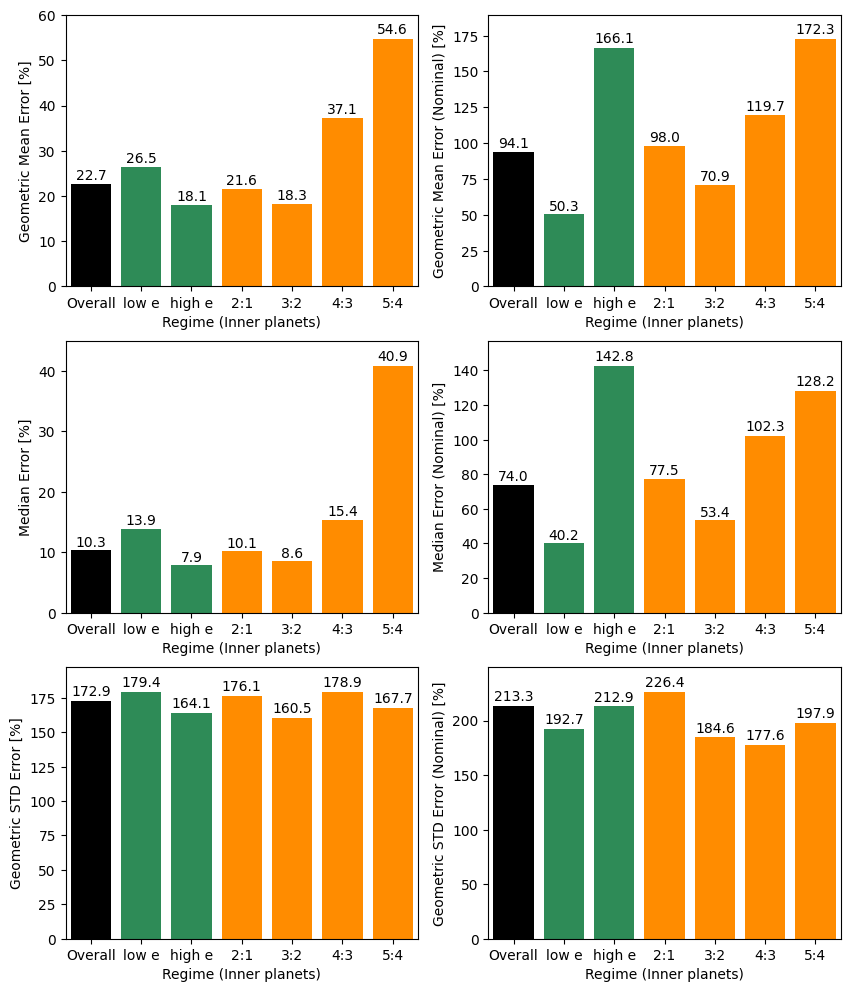

In [20]:
metricPlots(inner, 'Inner')

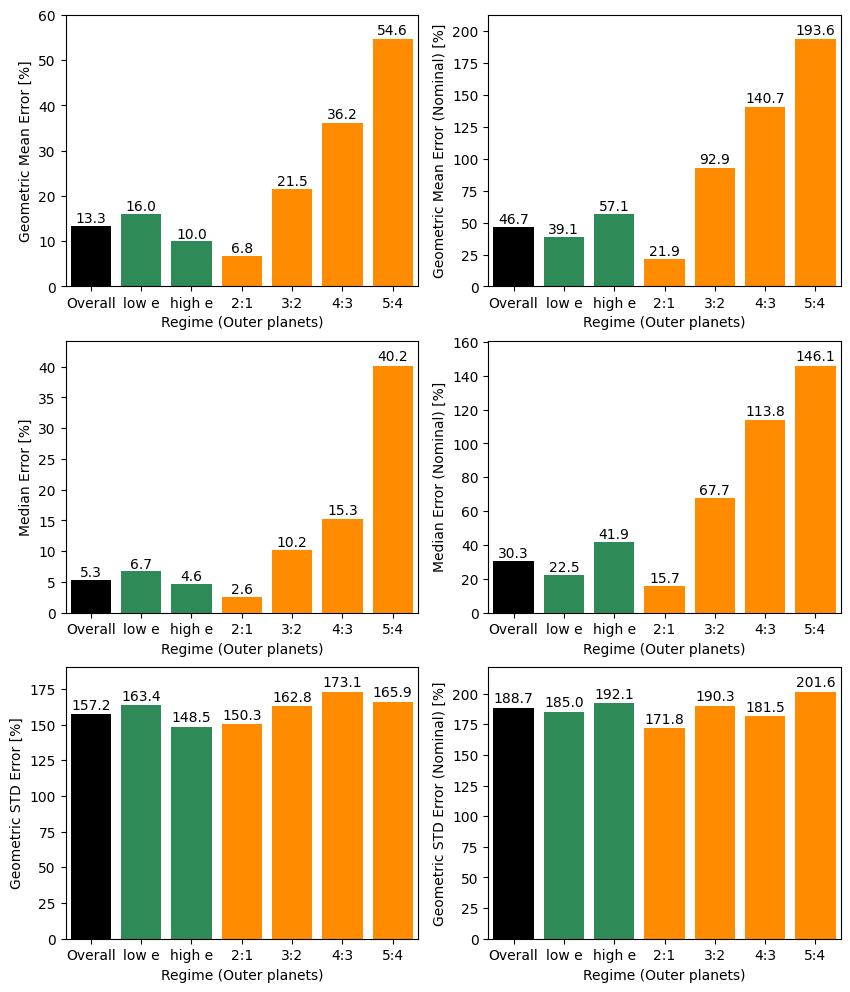

In [21]:
metricPlots(outer, 'Outer')